# Importing and formatting

In [1]:
import os
import pandas as pd
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/mathias/Documents/smartanalytics-city-98af3a209309.json"
import pandas as pd
import numpy as np

from google.cloud import bigquery

client = datastore.Client()


def get_toll_passes_by_day(start_date, end_date):

    toll_passes_day_query = client.query(kind="TollPassesDayAggregate")
    toll_passes_day_query.add_filter("date", ">=", start_date)
    toll_passes_day_query.add_filter("date", "<=", end_date)

    return fetch_query(toll_passes_day_query)




def fetch_query(query):
    query_result = list(query.fetch())
    entities = []
    for entity in query_result:
        entities.append(convert_query_result_to_dict(entity, "date"))
    return entities


def convert_query_result_to_dict(entity, key_name):
    result = dict(entity.items())
    result[key_name] = entity.key.name

    return result

def get_weather_by_day(start_date, end_date):
    weather_by_day_query = client.query(kind="WeatherDayAggregate")
    weather_by_day_query.add_filter("date", ">=", start_date)
    weather_by_day_query.add_filter("date", "<=", end_date)

    return fetch_query(weather_by_day_query)

def get_city_bike_by_day(start_date, end_date):
    city_bike_by_day_query = client.query(kind="CityBikeDayAggregate")
    city_bike_by_day_query.add_filter("date", ">=", start_date)
    city_bike_by_day_query.add_filter("date", "<=", end_date)

    return fetch_query(city_bike_by_day_query)

def get_bike_passes_by_day(start_date, end_date):
    bike_passes_by_day = client.query(kind="BikePassesDayAggregate")
    bike_passes_by_day.add_filter("date", ">=", start_date)
    bike_passes_by_day.add_filter("date", "<=", end_date)
    
    return fetch_query(bike_passes_by_day)

In [2]:
toll=get_toll_passes_by_day(start_date="2019-06-04", end_date="2021-04-30")
weather = get_weather_by_day(start_date="2019-06-04", end_date="2021-04-30")
cityBiketours = get_city_bike_by_day(start_date="2019-06-04", end_date="2021-04-30")
bikePasses = get_bike_passes_by_day(start_date="2019-06-04", end_date="2021-04-30")


In [3]:
dfToll = pd.DataFrame.from_dict(toll)
dfWeather = pd.DataFrame.from_dict(weather)
dfToll = dfToll[:-1]
dfCityBike = pd.DataFrame.from_dict(cityBiketours)
dfBikePasses = pd.DataFrame.from_dict(bikePasses)


In [4]:
# locating areas with missing data
from datetime import timedelta, datetime
bikedays = pd.to_datetime(dfCityBike["date"])
for i in range(len(bikedays)-1):
    
    if (bikedays[i+1]-bikedays[i]) != timedelta(days=1):
        print(bikedays[i], ' : ', bikedays[i+1])
        print(i)


2019-12-08 00:00:00  :  2020-03-17 00:00:00
187


In [5]:
# Concatenate cityBikedata onto a Dataframe with continuous timestamps
dates = pd.to_datetime(dfToll['date'])
dummy = [1]*len(dates)
dfDate = pd.DataFrame({
    
    'date' : dates,
    'dum' : dummy
})


dfCityBike['date'] = pd.to_datetime(dfCityBike['date'])
dfDate = dfDate.set_index('date')
dfCityBike = dfCityBike.set_index('date')
cityBikeWithNaN =pd.concat([dfCityBike, dfDate], axis=1)


In [6]:
# set the days from 2019-12-08 00:00:00  to  2020-03-17 00:00:00 as NaN


cityBikeWithNaN = cityBikeWithNaN.reset_index()
cityBikeTours=[]
for i in range(len(cityBikeWithNaN)):

    #print(bikeWithNaN['date'][i].month)
    if not (3 <= cityBikeWithNaN['date'][i].month <= 12):
        cityBikeTours.append(np.nan)
        #print(1)
    elif cityBikeWithNaN['date'][i].month == 12 and cityBikeWithNaN['date'][i].day >= 8 :
        cityBikeTours.append(np.nan)
        #print(2)
    elif cityBikeWithNaN['date'][i].month == 3 and cityBikeWithNaN['date'][i].day <= 17 :
        cityBikeTours.append(np.nan)
        #print(3)
    else:
        cityBikeTours.append(cityBikeWithNaN['trips'][i])
        #print(4)

    
monthArray = []
for i in range(len(cityBikeWithNaN['date'])):
    monthArray.append(cityBikeWithNaN['date'][i].month)
    
monthArray = monthArray[:-1]
cityBikeTours = cityBikeTours[:-1]

In [7]:
import datetime
def int2season():
    seasonArray = []
    seasons = {
        1 : [12,1,2],
        2 : [3,4,5],
        3 : [6,7,8],
        4 : [9,10,11]

    }

    seasonDict = {}

    for key,value in seasons.items():
        for v in value:
            seasonDict[v]=key
    
    for m in monthArray:
        seasonArray.append(seasonDict[m])
    #print(seasonDict)
    return seasonArray

def getDayOfWeek():
    weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
    days = []
    for date in dfToll['date']:
        weekDayAsInt = pd.to_datetime(date).weekday()

        days.append(weekDayAsInt)
    return days
weekdays = getDayOfWeek()


import holidays

def getRedDaysAsBoolean():
    redDays = []
    for i in range(len(dfToll['date'])):
        currentDate = pd.to_datetime(dfToll['date'][i])
        if currentDate in holidays.Norway() or (currentDate.day == 24 and currentDate.month == 12):
            #print(dfToll['date'][i])
            redDays.append(100)
        else:
            redDays.append(0)
    return redDays
            
        
        
        
def getDaysOfYear():
    daysOfYyear = []

    for i in range(len(dfToll['date'])):
        currentDate = pd.to_datetime(dfToll['date'][i])
        daysOfYyear.append(currentDate.timetuple().tm_yday)
    return daysOfYyear
        
    
        
redDays = getRedDaysAsBoolean()
daysOfYyear = getDaysOfYear()

seasons = int2season()
index=np.linspace(0,len(dates)-1,len(dates))

def weekdaySeasonFormatter(weekday,season):
    seasonToMonth = {
    1 : 1,
    2 : 4,
    3 : 7,
    4 : 10
    }
    month = seasonToMonth[season]
    ishDate = datetime.datetime(2019,month,15)
    dayNumber = ishDate.timetuple().tm_yday
    return month,dayNumber

### Note that some parameters in the X array are removed or added when training certain models

In [100]:


X = np.array([seasons,monthArray,weekdays,daysOfYyear,redDays,dfWeather["avgTemperature"],dfWeather["avgWindSpeed"],dfWeather["avgPrecipitation"],dfWeather["avgRelativeHumidity"],dfWeather["avgCloudAreaFraction"],dfWeather["avgDurationOfSunshine"],index])
Y = np.array([dfToll["dieselPasses"],dfToll["petrolPasses"],dfToll["zeroEmissionPasses"], cityBikeTours, dfBikePasses['totalPasses']],np.float32)


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

standard_scaling = StandardScaler()
Y_NoNaN = Y.T
nan_index = np.isnan(Y_NoNaN)
Y_NoNaN[nan_index] = 0
X_Standard = standard_scaling.fit_transform(X[:-1].T)
Y_Standard = standard_scaling.fit_transform(Y_NoNaN)



X_train, X_test, y_train, y_test = train_test_split(
    X.T, Y_NoNaN, test_size=0.2, random_state=41)

indexKept = X_test.T[-1]
X_train = X_train.T[:-1].T
X_test = X_test.T[:-1].T
#y_train = y_train.T[:-1].T
#y_test = y_test.T[:-1].T




In [102]:
XY_standard = np.append(X_Standard.T,Y_Standard.T,axis=0)
XY_standard.shape

(16, 696)

# PCA 
### This was only used to analyze what data had explanitory power

In [163]:
from sklearn.decomposition import PCA
standard_scaling = StandardScaler()

pca= PCA(n_components=16)
projected = pca.fit_transform(XY_standard.T)



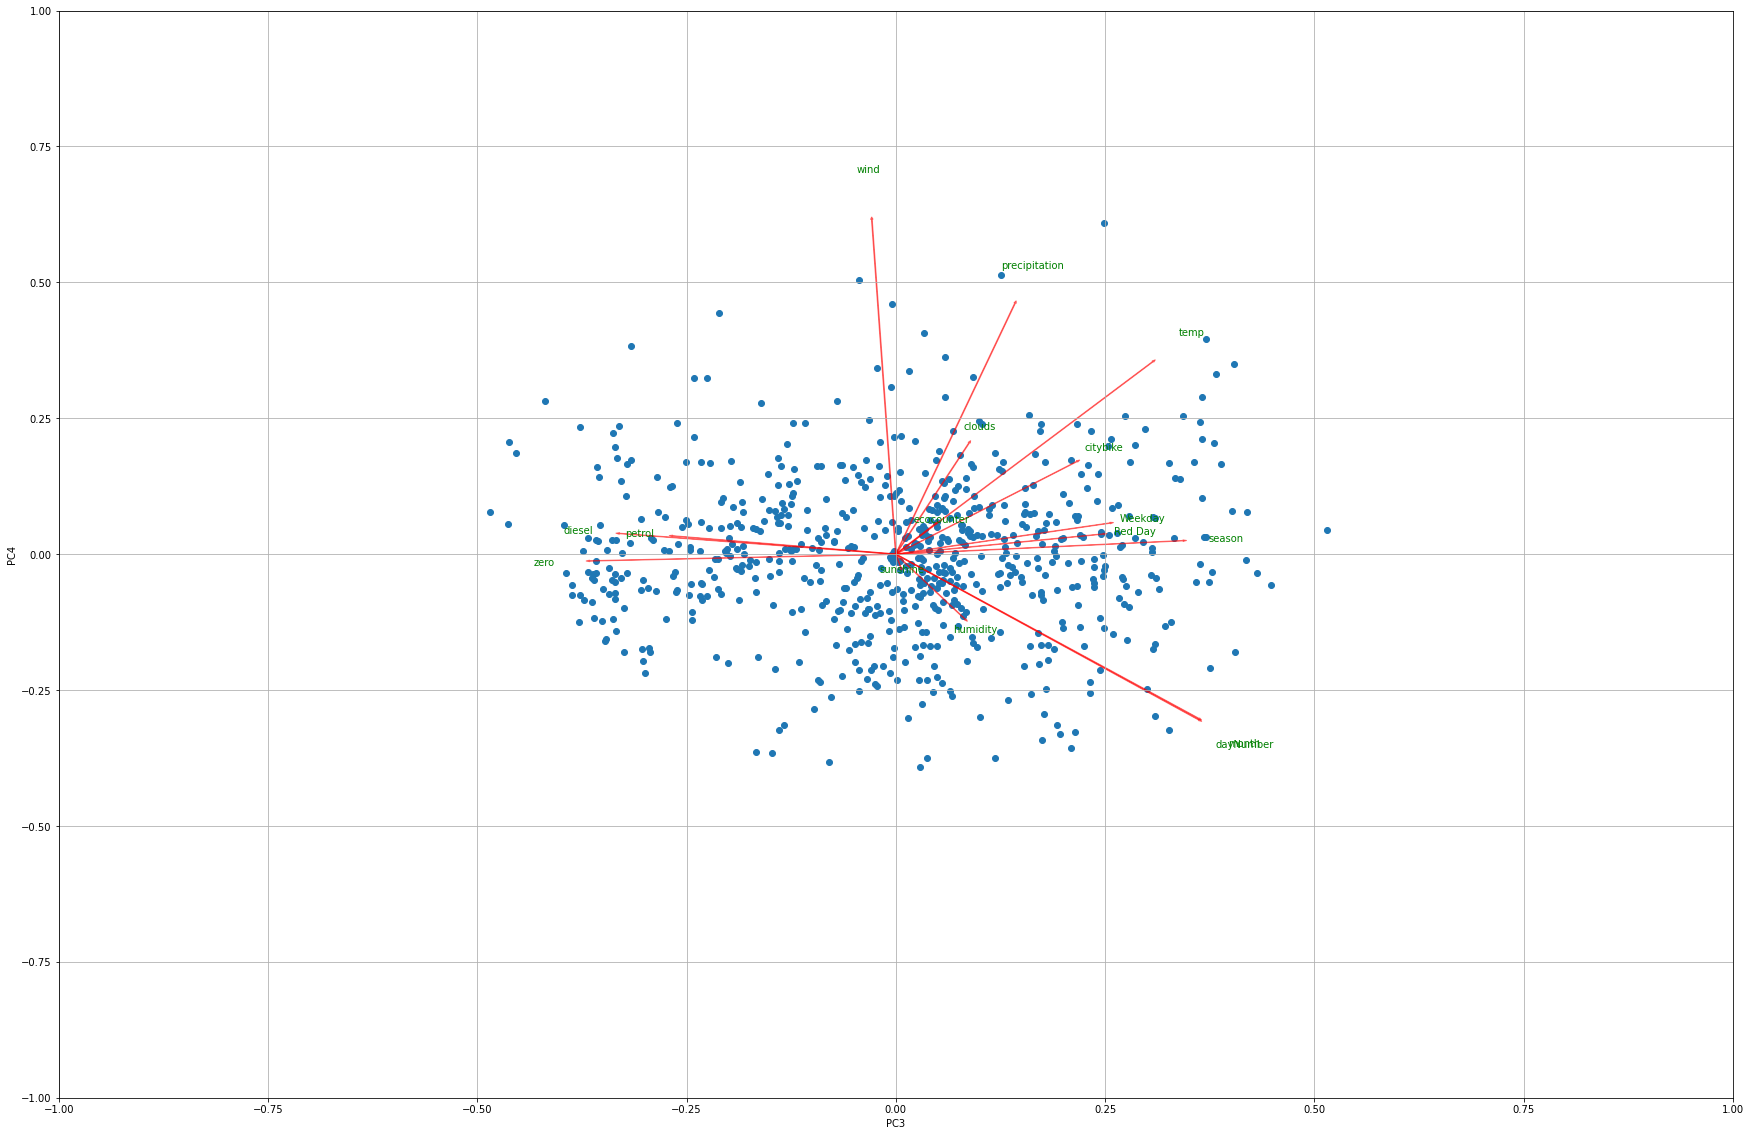

In [167]:
labels = ["season","month","Weekday","dayNumber","Red Day","temp","wind","precipitation","humidity","clouds","sunshine","diesel","petrol","zero","citybike","ecocounter"]
len(labels)
def myplot(projected,comp1,comp2,labels=None):
    coeff=np.transpose([np.transpose(pca.components_[comp1-1:comp1, :]),np.transpose(pca.components_[comp2-1:comp2, :])])
    coeff=coeff[0]
    xs = projected.T[comp1-1]
    ys = projected.T[comp2-1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(30,20))
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(comp1))
    plt.ylabel("PC{}".format(comp2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(projected,3,4,labels)

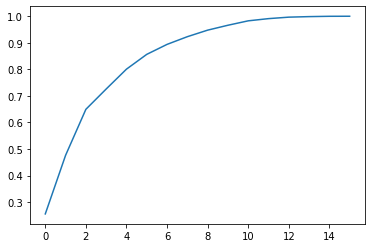

In [166]:
pca = PCA().fit(XY_standard.T)
#plt.figure(figsize=(15,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Partial least squares regression

In [90]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=10)
pls.fit(X_train, y_train)

Y_pred = pls.predict(X_test)


/home/mathias/.local/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(10) should be in [1, n_features].n_components=9 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


In [91]:
explained_variance_score(Y_pred.T[2],y_test.T[2])

-1.3032447466527857

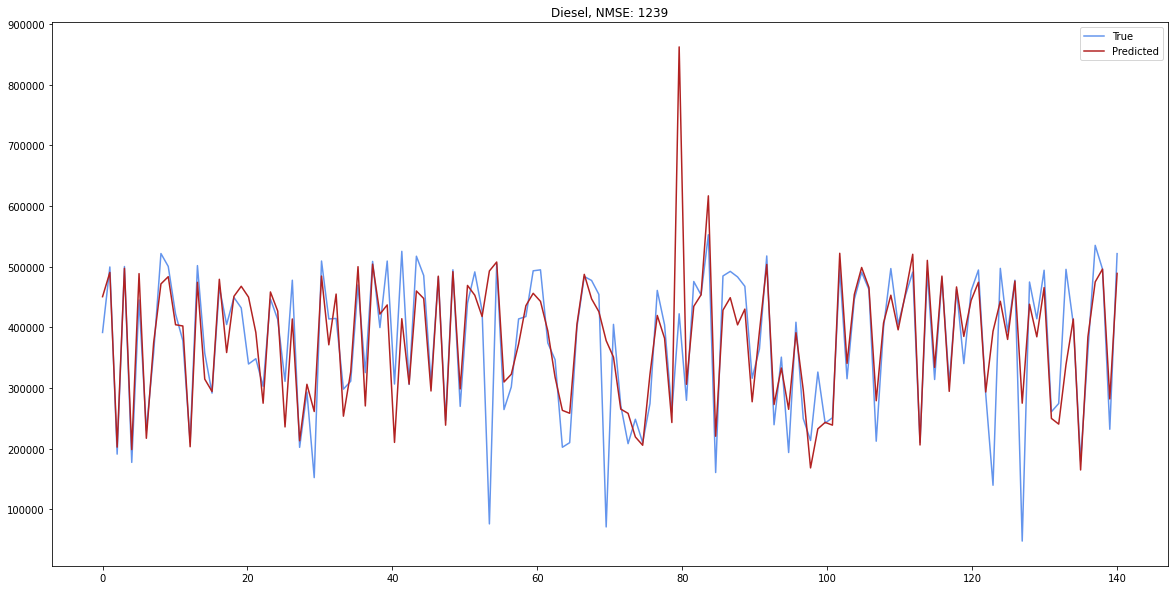

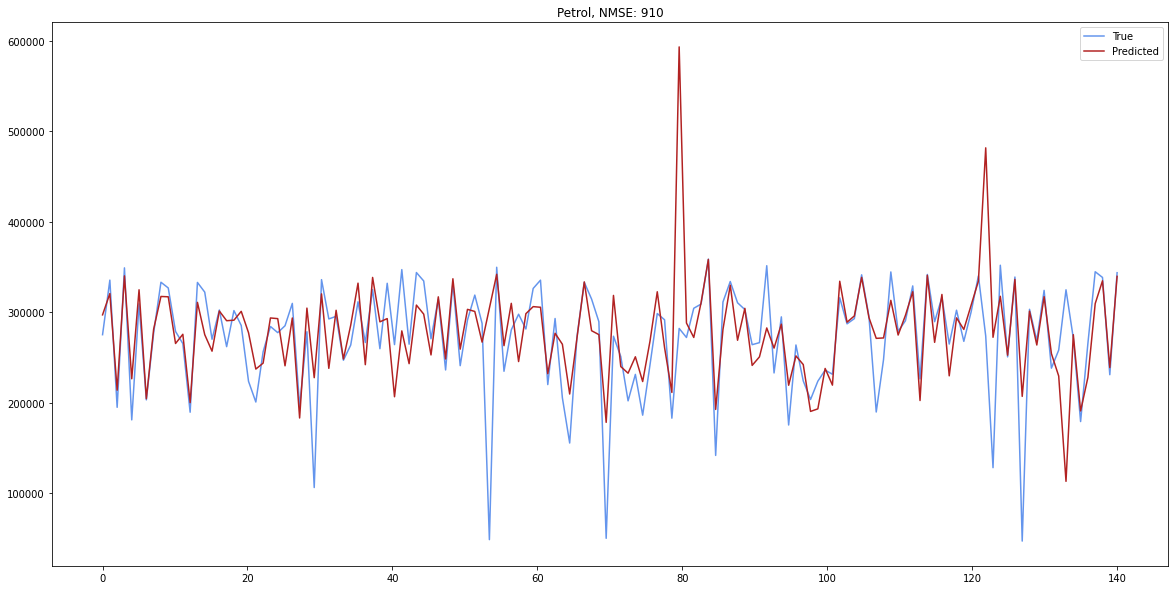

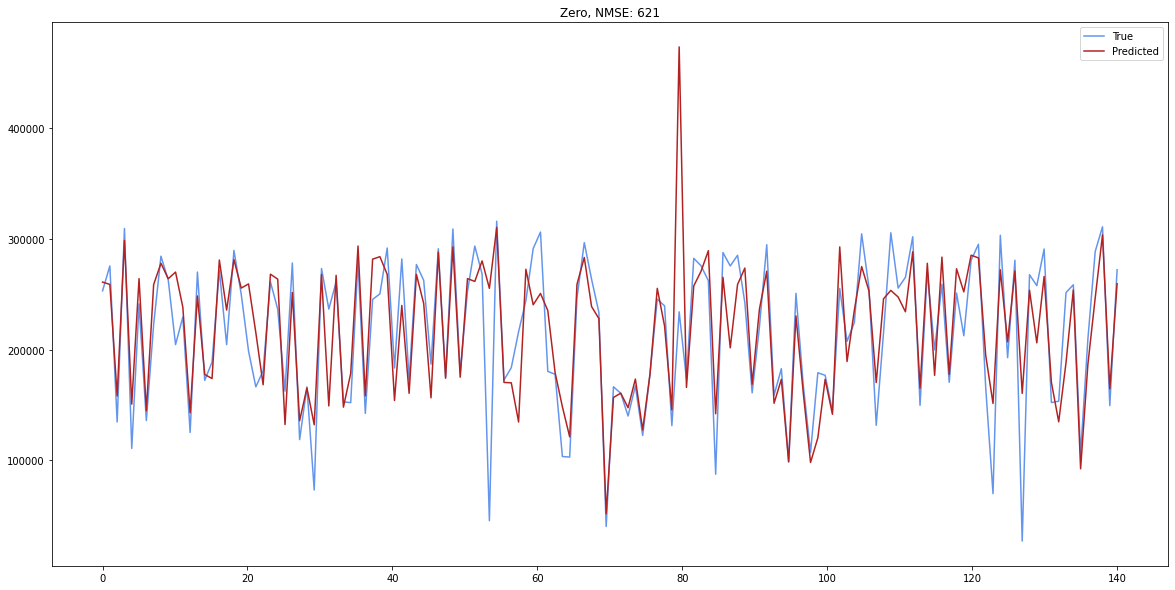

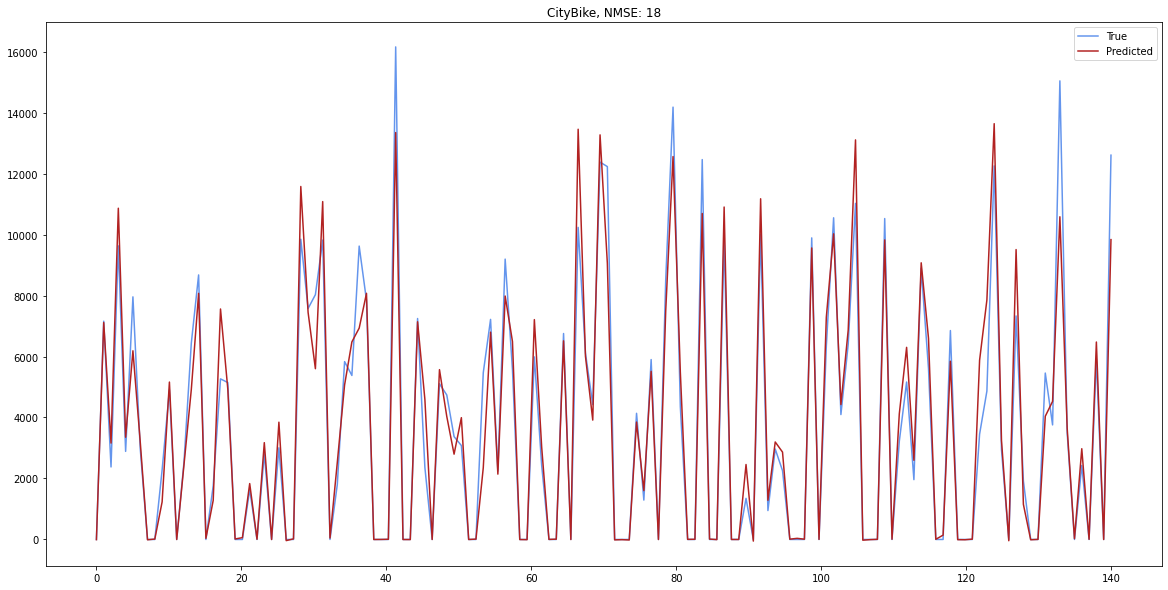

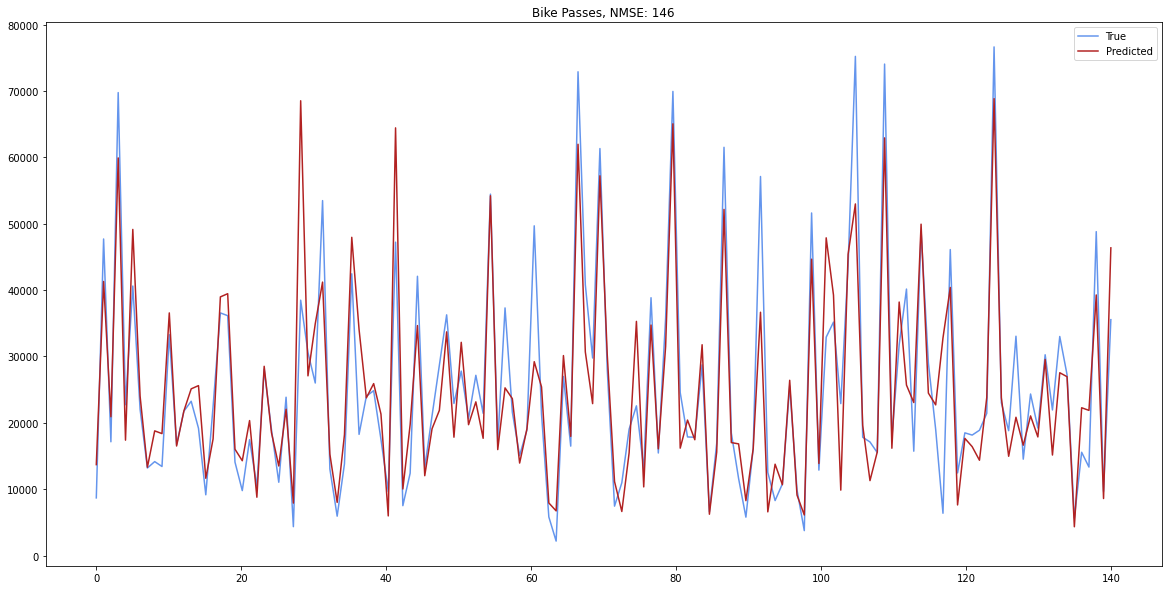

In [172]:
from sklearn.metrics import mean_squared_error as mse
import numpy.linalg as linalg


def getNMSE(y_hat,y):
    return round((mse(y_hat,y))/linalg.norm(y))

def plotResults(y_hat,y,category,fignum=1):
    NMSE = getNMSE(y_hat,y)
    t = np.linspace(0,len(y),num=len(y))
    plt.figure(fignum,figsize=(20,10))
    
    plt.plot(t,y,color='cornflowerblue',label="True")
    plt.plot(t,y_hat,color='firebrick',label="Predicted")
    plt.legend()
    plt.title(f"{category}, NMSE: {NMSE}")

plotResults(Y_pred.T[0],y_test.T[0],"Diesel",1)
plotResults(Y_pred.T[1],y_test.T[1],"Petrol",2)
plotResults(Y_pred.T[2],y_test.T[2],"Zero",3)
plotResults(Y_pred.T[3],y_test.T[3],"CityBike",4)
plotResults(Y_pred.T[4],y_test.T[4],"Bike Passes",5)

MSEDiesel = getNMSE(Y_pred.T[0],y_test.T[0])
MSEPetrol = getNMSE(Y_pred.T[1],y_test.T[1])
MSEZero = getNMSE(Y_pred.T[2],y_test.T[2])
MSECityBicycle = getNMSE(Y_pred.T[3],y_test.T[3])
MSEBicycle = getNMSE(Y_pred.T[4],y_test.T[4])


PlsNMSEArray = [MSEDiesel,MSEPetrol,MSEZero,MSECityBicycle,MSEBicycle]

In [93]:
MSEMatrix = []
for i in range(1,9):
    
    pls4 = PLSRegression(n_components=i)
    pls4.fit(X_train, y_train)

    Y_pred = pls4.predict(X_test)

    MSEDiesel = round(mse(y_test.T[0],Y_pred.T[0])/np.std(y_test.T[0]))
    MSEPetrol = round(mse(y_test.T[1],Y_pred.T[1])/np.std(y_test.T[1]))
    MSEZero = round(mse(y_test.T[2],Y_pred.T[2])/np.std(y_test.T[2]))
    MSEBicycle = round(mse(y_test.T[3],Y_pred.T[3])/np.std(y_test.T[3]))
    MSEMatrix.append([MSEDiesel,MSEPetrol,MSEZero,MSEBicycle])


Text(0, 0.5, 'Normalized mean square error')

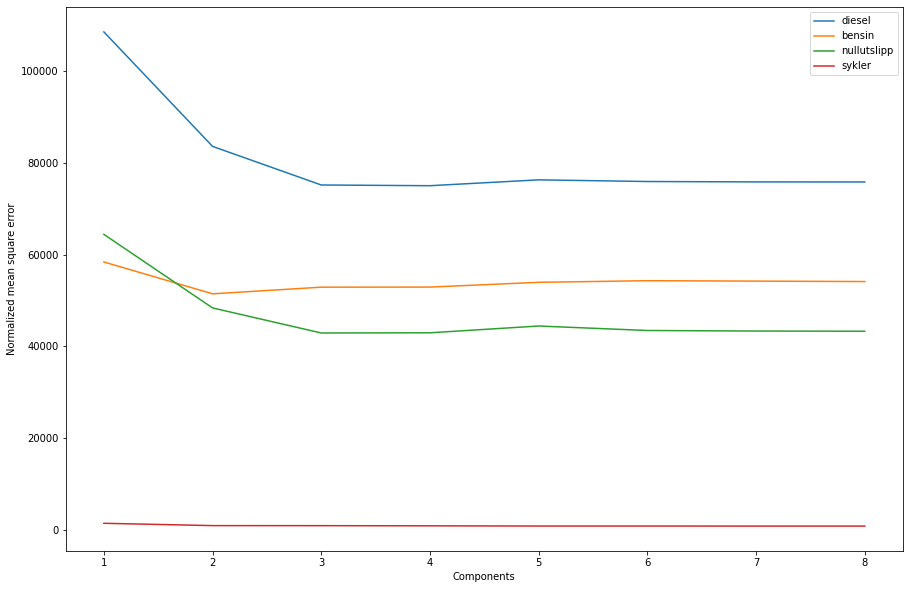

In [94]:
variabler = ["diesel","bensin", "nullutslipp", "sykler"]
plt.figure(figsize=(15,10))
t1 = np.linspace(1,len(MSEMatrix),len(MSEMatrix))
for i in range(4):
    plt.plot(t1,np.array(MSEMatrix).T[i],label=f"{variabler[i]}")
    plt.legend()
plt.xlabel("Components")
plt.ylabel("Normalized mean square error")

# XGBoost
### This is the model we ended up using and it is exported as "savedModel.sav"


In [95]:
from sklearn.multioutput import MultiOutputRegressor


from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 1000,max_depth = 8)

mor = MultiOutputRegressor(model)

mor.fit(X_train,y_train)

Y_pred = mor.predict(X_test)
y_pred_diesel = Y_pred.T[0]
y_pred_petrol = Y_pred.T[1]
y_pred_zero = Y_pred.T[2]
y_pred_city_bikes = Y_pred.T[3]
y_pred_bike_passes = Y_pred.T[4]

#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(mor, X_train,y_train, cv=10)


/home/mathias/.local/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


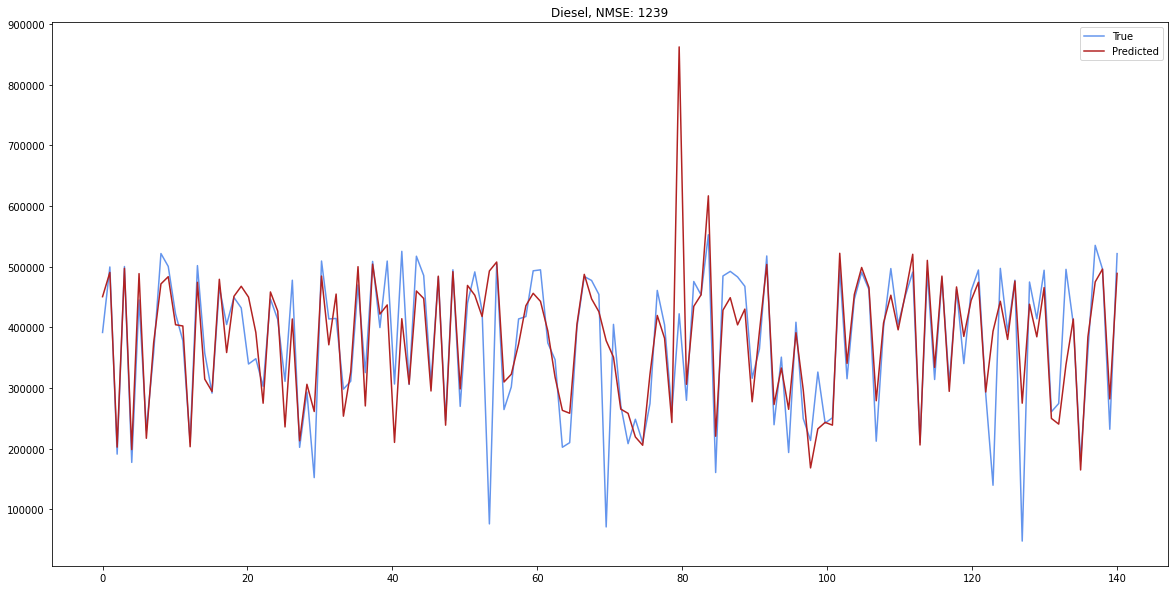

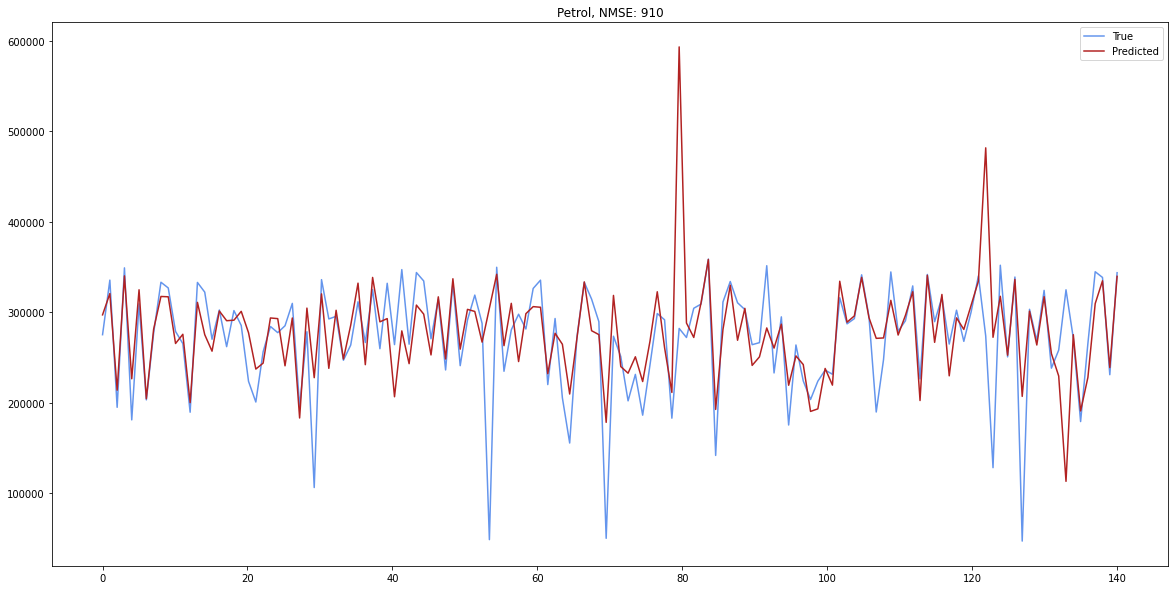

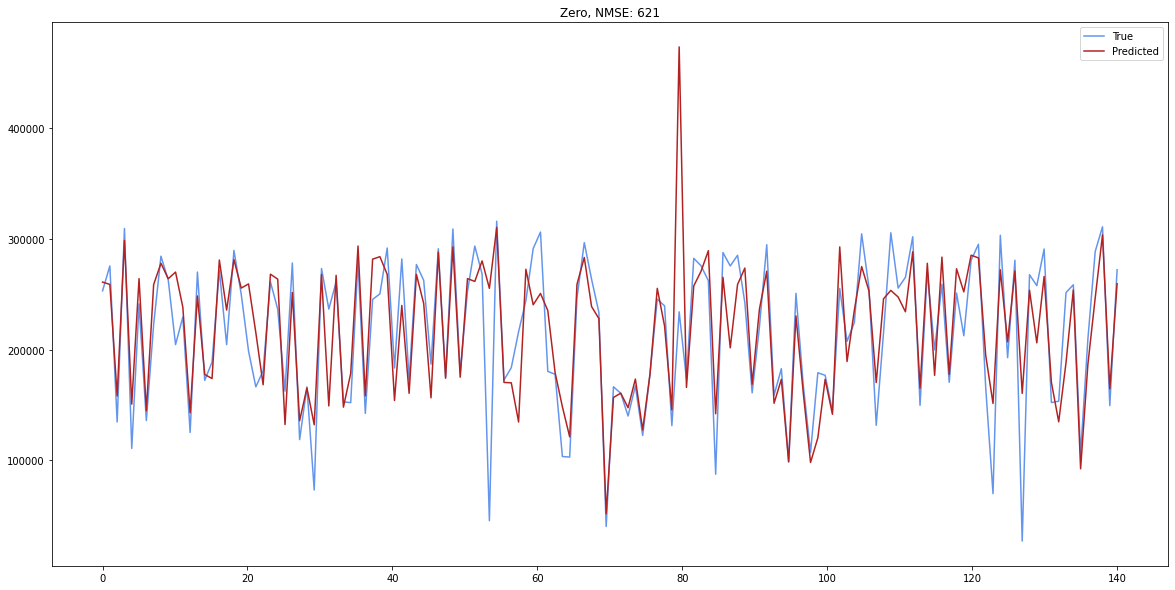

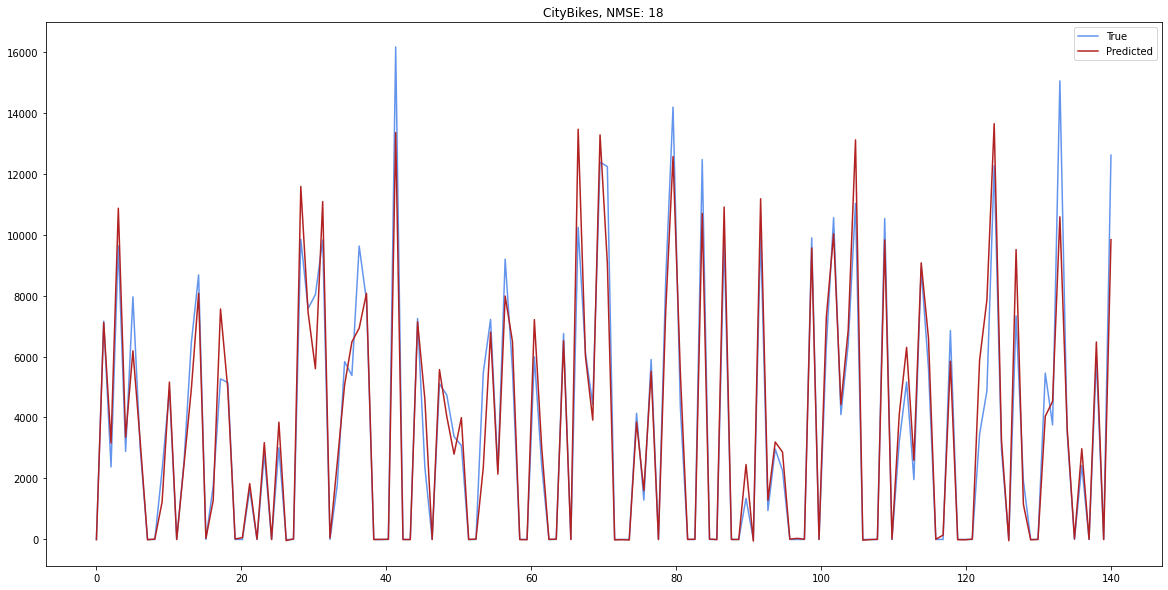

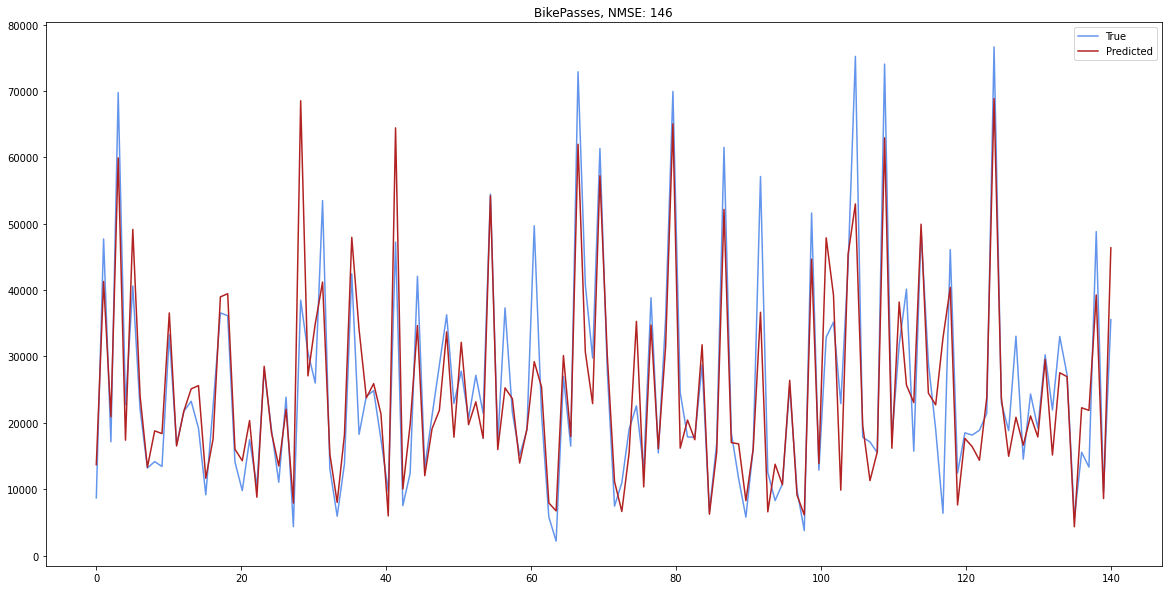

In [174]:
plotResults(y_pred_diesel,y_test.T[0],"Diesel",1)
plotResults(y_pred_petrol,y_test.T[1],"Petrol",2)
plotResults(y_pred_zero,y_test.T[2],"Zero",3)
plotResults(y_pred_city_bikes,y_test.T[3],"CityBikes",4)
plotResults(y_pred_bike_passes,y_test.T[4],"BikePasses",5)

MSEBoostDiesel = getNMSE(y_pred_diesel,y_test.T[0])
MSEBoostPetrol = getNMSE(y_pred_petrol,y_test.T[1])
MSEBoostZero = getNMSE(y_pred_zero,y_test.T[2])
MSEBoostCityBikes = getNMSE(y_pred_city_bikes,y_test.T[3])
MSEBoostBikePasses = getNMSE(y_pred_bike_passes,y_test.T[4])

BoostNMSEArray = [MSEBoostDiesel, MSEBoostPetrol, MSEBoostZero, MSEBoostCityBikes,MSEBoostBikePasses]

In [98]:
# Save Model
import joblib
#joblib.dump(mor,"XGBoostCars.sav")

# joblib.load(filename) to retrieve model

['savedModel.sav']

Text(0.5, 1.0, 'NMSE for boosting and plsr')

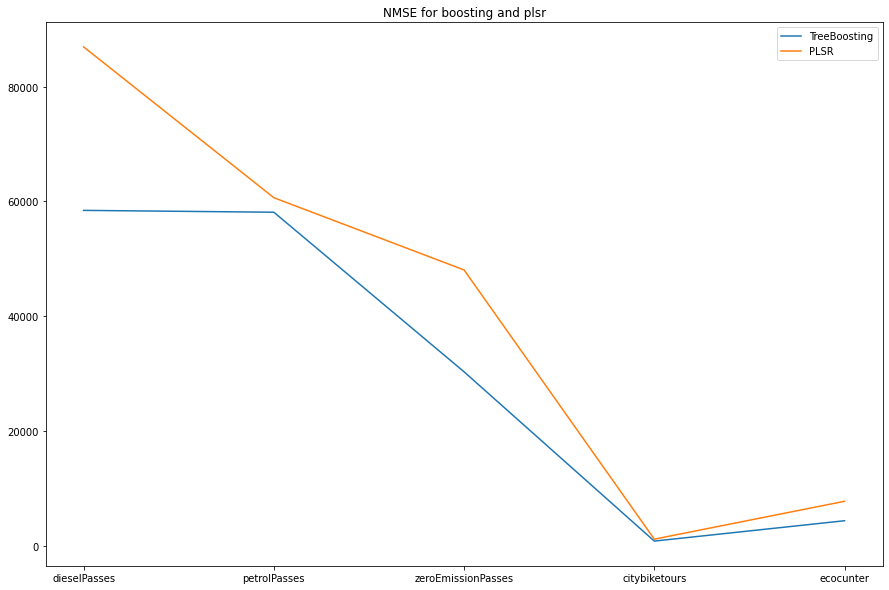

In [29]:
plt.figure(figsize=(15,10))
names = ['dieselPasses', 'petrolPasses', 'zeroEmissionPasses','citybiketours','ecocunter']
plt.plot(names, BoostNMSEArray,label="TreeBoosting")
plt.plot(names, PlsNMSEArray, label="PLSR")
plt.legend()
plt.title("NMSE for boosting and plsr")

